In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, median_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import os

## GPR on different data quality

In [19]:
def f_loglin(x, x_c=1):
    return np.where(x < x_c, (x-x_c)/x_c+np.log(x_c), np.log(x))
def f_loglin_inv(y, y_c=0):
    return np.where(y < y_c, (1+y-y_c)*np.exp(y_c), np.exp(y))
def f_loglin_deriv(x, x_c=1):
    return np.where(x < x_c, 1/x_c, 1/x)

def f_mse(y, y_gt):
    return np.mean((y-y_gt)**2)/np.mean((y_gt)**2)

def desmear(Q,IQ,IQ_er,sigma_Q,n=3,sigmascale=1):
    I_ex = IQ
    I_ex_pos = I_ex[2*n:]
    I_ex_neg = I_ex[:-2*n]
    I_ex = I_ex[n:-n]
    sigma_Q_c = sigma_Q[n:-n]/sigmascale
    # sigma_Q_c = Q[n:-n]

    DQ = Q[n:] - Q[:-n]
    DQ_pos = DQ[n:]
    DQ_neg = DQ[:-n]

    I_ex2 = 2*(DQ_neg*I_ex_pos + DQ_pos*I_ex_neg - I_ex*(DQ_pos+DQ_neg))/(DQ_pos*DQ_neg*(DQ_pos+DQ_neg))
    I_des = I_ex - sigma_Q_c**2/2*I_ex2
    Q_des = Q[n:-n]

    return I_des

def f_log_likelihood(y, y_err, x, x_err, z_list = np.linspace(0, 0, 1), importance = None, index = None):
    """
    likelihood of y in the distribution of x
    """
    ## average over the ovservation uncertainty   
    log_likelihood = 0   
    sum_weight = 0  
    
    if importance is None:
        importance = np.ones(len(y))
    if index is None:
        index = np.arange(len(y))
    
    for z in z_list:
        weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
        y_z = y + y_err*z
        log_likelihood_z = -0.5 * np.sum((((y_z - x)**2 / x_err**2 + np.log(2 * np.pi * x_err**2))*importance)[index])
        log_likelihood += log_likelihood_z*weight_z
        sum_weight += weight_z
    log_likelihood = log_likelihood/sum_weight
    return log_likelihood



## CVWLM2 9m15a

0 120.0
1 240.0
2 360.0
3 480.0
4 600.0
5 720.0
6 840.0
7 960.0
8 1080.0
9 1200.0
10 1320.0
11 1440.0
12 1560.0
13 1680.0
14 1800.0
15 1920.0
16 2040.0
17 2160.0
18 2280.0
19 2400.0
20 2520.0
21 2640.0
22 2760.0
23 2880.0
24 3000.0
25 3120.0
26 3240.0
27 3360.0
28 3480.0
29 3600.0


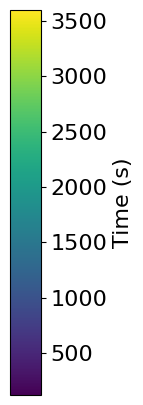

In [20]:
# Define the folder path
folder_path = './data/EQSANS/output_22386/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[5]) for filename in filenames if filename.endswith('.dat') and '9m15a' in filename and 'CVWLM1' in filename])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f'CVWLM2_20C_9m15a_time_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt(folder_path+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])
    
# Create a vertical colorbar according to the time list in viridis colormap
fig, ax = plt.subplots(figsize=(0.4, 5))
norm = plt.Normalize(vmin=time_list.min(), vmax=time_list.max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=ax)
cbar.set_label('Time (s)', fontsize=16)
cbar.ax.tick_params(labelsize=16)

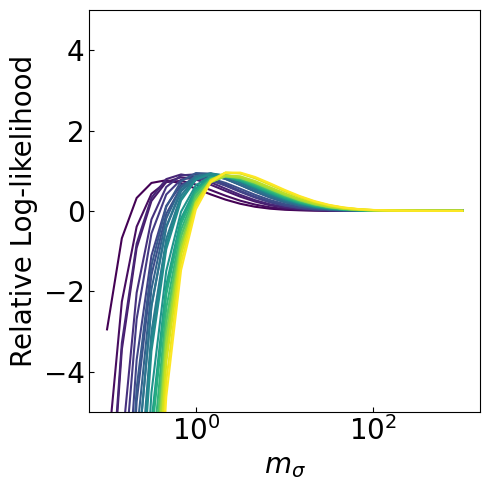

In [21]:
n_trial = 1
filter_size = 0.2
I_bg = 1
use_log_I = False
use_log_Q = True

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

fig = plt.figure(figsize=(5, 5))

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 7, 13)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []

list_I_mean_gp = []
list_I_std_gp = []

for i_t, time in enumerate(time_list):
    
    ax = plt.subplot(1, 1, 1)

    color = get_viridis_color(i_t/(len(time_list)-1))


    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        # The noisy data
        index_data = i_t
        data = data_list[index_data]
        q_data = data[:, 0]
        I_data = data[:, 1]
        I_err_data = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data)):
            if I_err_data[i] == 0:
                I_err_data[i] = I_err_data[i - 1]
                
        # The smooth data
        index_data_good = len(time_list)-1
        data = data_list[index_data_good]
        q_data_good = data[:, 0]
        I_data_good = data[:, 1]
        I_err_data_good = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data_good)):
            if I_err_data_good[i] == 0:
                I_err_data_good[i] = I_err_data_good[i - 1]
                
        index_outlier_sm = (q_data > 0.03)|(q_data < 0.001)  
        index_outlier = (q_data < 0.03)&(q_data > 0.001)
        
        I_q_gf = np.zeros_like(q_data)
        for i_iterate in range(5):
            I_q_gf_i = np.zeros_like(q_data)
            I_iterate = I_data - I_q_gf
            for i in range(len(q_data)):
                weight_list = np.exp(-((f_Q(q_data[i])-f_Q(q_data))/filter_size)**2/2)
                weight_list[index_outlier_sm] = 0
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 1
            # I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q_data), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i

        ## GPR
        sigma_list = np.logspace(-1, 3, 25)
        log_likelihood_list = []
        
        lmbda = 0.25
        # sigma = 10

        ## define kernel function
        y_data = f_I(I_data)
        y_gt = f_I(I_data_good)
        y_bg = f_I(I_q_gf)
        # y_bg = y_gt
        y = y_data-y_bg

        # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
        y_err_pixel = I_err_data
        y_err = y_err_pixel
        if use_log_I:
            y_err = y_err_pixel*f_loglin_deriv(I_data, x_c=I_bg*2)

        # scale by a factor to check whether error estimation is correct
        m_factor = 1
        y_bg = y_bg*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
        y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
        y_data = y_data*m_factor
        sig_var = np.mean(y[index_outlier]**2)
        
        # # exclude outliers
        # y_bg = y_bg[index_outlier]
        # y_gt = y_gt[index_outlier]
        # y = y[index_outlier]
        # y_err = y_err[index_outlier]
        # y_data = y_data[index_outlier]
        # q_data = q_data[index_outlier]

        # fluctuations of the prior distribution
        prior_sigma = np.sqrt(sig_var)
        # prior_sigma = np.sqrt(np.mean(y_err**2))
        # prior_sigma = np.sqrt(y_err**2+sig_var) 

        q_x = q_data
        q_s = q_data

        def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
            if std_1 is None:
                std_1 = np.ones_like(q1)
            if std_2 is None:
                std_2 = np.ones_like(q2)
            K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
            return K
        
        for sigma in sigma_list:
            f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
            K_sigma = np.diag(f_y_err(y_err))
            # K_sigma = sigma**2*np.eye(len(q_x))
            K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
            K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
            k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

            L = np.linalg.cholesky(K_xx)
            alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
            v = np.linalg.solve(L, K_xs)
            mu_s = K_xs.T @ alpha
            cov_s = k_ss - v.T @ v
            var_s = np.diag(cov_s)*prior_sigma**2
            std_s = np.sqrt(var_s)

            # evaluate the log likelihood
            log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
            log_likelihood_list.append(log_likelihood)
            
        log_likelihood_list = np.array(log_likelihood_list)
        log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        ax.plot(sigma_list, log_likelihood_list, '-', color=color)
        ax.set_xscale('log')
        ax.set_ylim([-5, 5])
        ax.tick_params(direction='in', labelsize=20)
        ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        # sigma_best = 1
        
        # ax.legend(frameon=False, fontsize=13, ncol=2)
        plt.tight_layout()

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_data, x_c=I_bg*2)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy              
        importance = np.where((q_data > 0.03)|(q_data < 0.001) , 0, 1)
        # importance = None
        
        # h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)

        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
        # likelihood of gt within the experimental prediction
        # log_likelihood_gt_exp += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), f_inv_I(y_data), y_err_pixel)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_exp += f_log_likelihood((y_gt), sigma_gt, y_data, y_err_pixel)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # likelihood of gt within the GPR prediction
        # log_likelihood_gt_gpr += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), I_mean_GP, I_std_GP)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_gpr += f_log_likelihood((y_gt), sigma_gt, mu_s + y_bg, std_s)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # mean squared error of gt and experimental prediction
        # mse_exp += f_mse(y + y_bg, y_gt)
        mse_exp += f_mse(f_inv_I(y_data),f_inv_I(y_gt))
        
        # mean squared error of gt and GPR prediction
        # mse_gpr += f_mse(mu_s + y_bg, y_gt)
        mse_gpr += f_mse(I_mean_GP, f_inv_I(y_gt))
        
    list_I_mean_gp.append(I_mean_GP)
    list_I_std_gp.append(I_std_GP)        
        
    list_L_exp.append(log_likelihood_gt_exp/n_trial)
    list_L_gpr.append(log_likelihood_gt_gpr/n_trial)
    list_mse_exp.append(mse_exp/n_trial)
    list_mse_gpr.append(mse_gpr/n_trial)
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)

# convert the lists to numpy arrays
list_L_exp = np.array(list_L_exp)
list_L_gpr = np.array(list_L_gpr)
list_mse_exp = np.array(list_mse_exp)
list_mse_gpr = np.array(list_mse_gpr)
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

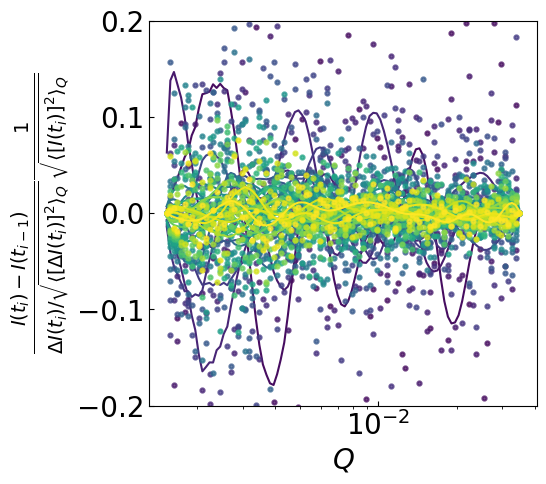

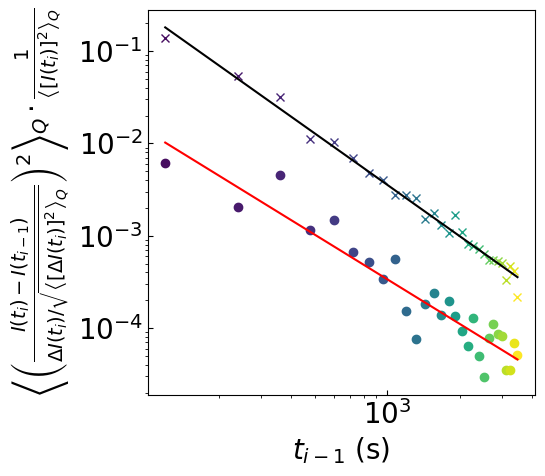

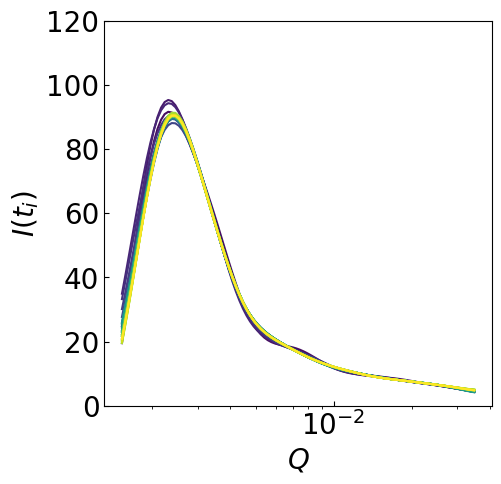

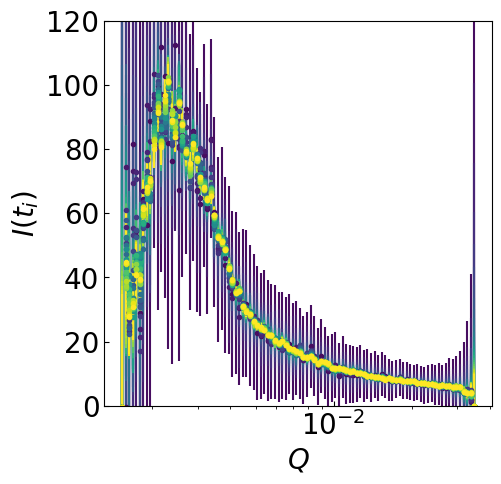

In [35]:
# plot the GPR result
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

fig2 = plt.figure(figsize=(5, 5))
ax2 = plt.subplot(1, 1, 1)

fig3 = plt.figure(figsize=(5, 5))
ax3 = plt.subplot(1, 1, 1)

fig4 = plt.figure(figsize=(5, 5))
ax4 = plt.subplot(1, 1, 1)

colors = plt.cm.viridis(np.linspace(0, 1, len(time_list)))

list_mse = []
list_mse_exp = []

i_selected = np.logspace(0, np.log10(len(time_list)-1), 4).astype(int)

panel_labels = ['(a)', '(b)', '(c)', '(d)']

for i_t, time in enumerate(time_list):
    if i_t == 0:
        continue
    
    time_prev = time_list[i_t-1]
    # if i_t not in i_selected:
    #     continue
    I_gp_prev = list_I_mean_gp[i_t-1]
    I_gp = list_I_mean_gp[i_t]
    I_gp_err = list_I_std_gp[i_t]

    data = data_list[i_t]
    q_data = data[:, 0]
    I_exp = data[:, 1]
    I_exp_err = data[:, 2]
    mean_I_gp = np.mean(I_gp)
    mean_I_exp = np.mean(I_exp)
    
    data_prev = data_list[i_t-1]
    q_data_prev = data_prev[:, 0]
    I_exp_prev = data_prev[:, 1]
    I_exp_err_prev = data_prev[:, 2]
    mean_I_gp_prev = np.mean(I_gp_prev)
    mean_I_exp_prev = np.mean(I_exp_prev)
    
    relative_err_Q = I_exp_err/np.sqrt(np.mean(I_exp_err**2))*np.sqrt(np.mean((I_exp-np.mean(I_exp))**2)) # dimensionless
    
    # ax.plot(q_s, ((I_exp-mean_I_exp)-(I_exp_prev-mean_I_exp_prev))/relative_err_Q, '.', color=colors[i_t], alpha=0.75, markeredgewidth=1.5)
    # ax.plot(q_s, ((I_gp-mean_I_gp)-(I_gp_prev-mean_I_gp_prev))/relative_err_Q, '-', color = colors[i_t])
    ax.plot(q_s, (I_exp-I_exp_prev)/relative_err_Q, '.', color=colors[i_t], alpha=0.75, markeredgewidth=1.5)
    ax.plot(q_s, (I_gp-I_gp_prev)/relative_err_Q, '-', color = colors[i_t])
    ax.set_xlabel(r'$Q$', fontsize=20)
    ax.set_ylabel(r'$\frac{I(t_i) - I(t_{i-1})}{\Delta I(t_i)/\sqrt{\langle \left[\Delta I(t_i)\right]^2 \rangle_Q}} \frac{1}{\sqrt{\langle \left[I(t_i)\right]^2 \rangle_Q}}$', fontsize=20)
    ax.set_xscale('log')
    ax.set_ylim([-0.2, 0.2])
    ax.tick_params(direction='in', labelsize=20)
    
    ax2.plot(time_prev, np.mean(((I_gp-I_gp_prev)/relative_err_Q)**2), 'o', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.plot(time_prev, np.mean(((I_exp-I_exp_prev)/relative_err_Q)**2), 'x', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_xlabel(r'$t_{i-1}\ (\mathrm{s})$', fontsize=20)
    ax2.set_ylabel(r'$\left\langle \left( \frac{I(t_i) - I(t_{i-1})}{\Delta I(t_i)/\sqrt{\left\langle \left[\Delta I(t_i)\right]^2 \right\rangle_Q}} \right)^2 \right\rangle_Q \cdot \frac{ 1 }{ \left\langle \left[I(t_i)\right]^2 \right\rangle_Q }$', 
                   fontsize=20)
    ax2.tick_params(direction='in', labelsize=20)
    
    ax3.plot(q_s, I_gp_prev, '-', color = colors[i_t])
    ax3.set_xlabel(r'$Q$', fontsize=20)
    ax3.set_ylabel(r'$I(t_i)$', fontsize=20)
    ax3.set_xscale('log')
    ax3.tick_params(direction='in', labelsize=20)
    # ax3.set_yscale('log')
    ax3.set_ylim([0, 120])
    ylim = ax3.get_ylim()
    
    ax4.errorbar(q_data, I_exp, yerr=I_exp_err, fmt='.', color = colors[i_t])
    ax4.set_xlabel(r'$Q$', fontsize=20)
    ax4.set_ylabel(r'$I(t_i)$', fontsize=20)
    ax4.set_xscale('log')
    ax4.tick_params(direction='in', labelsize=20)
    ax4.set_ylim(ylim)
    # ax4.set_yscale('log')
    
    list_mse.append(np.mean(((I_gp-I_gp_prev)/relative_err_Q)**2))
    list_mse_exp.append(np.mean(((I_exp-I_exp_prev)/relative_err_Q)**2))
# convert the lists to numpy arrays
list_mse = np.array(list_mse)
list_mse_exp = np.array(list_mse_exp)
    

log_time = np.log(time_list[:-1])
log_mse = np.log(list_mse)
log_mse_exp = np.log(list_mse_exp)

# Prepare the X matrix with ones and log_time
X = np.vstack([np.ones_like(log_time), log_time]).T

# Solve for coefficients using least squares
A, _, _, _ = np.linalg.lstsq(X, log_mse, rcond=None)
A_exp, _, _, _ = np.linalg.lstsq(X, log_mse_exp, rcond=None)

slope, intercept = A[1], A[0]
slope_exp, intercept_exp = A_exp[1], A_exp[0]

ax2.plot(time_list[:-1], np.exp(intercept + slope * log_time), color='r', alpha=1)
ax2.plot(time_list[:-1], np.exp(intercept_exp + slope_exp * log_time), color='k', alpha=1)

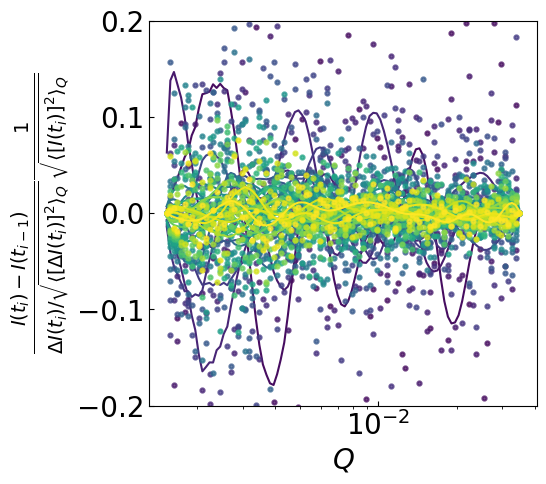

In [23]:
# plot the GPR result
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

colors = plt.cm.viridis(np.linspace(0, 1, len(time_list)))

list_mse = []
list_mse_exp = []

i_selected = np.logspace(0, np.log10(len(time_list)-1), 4).astype(int)

panel_labels = ['(a)', '(b)', '(c)', '(d)']



for i_t, time in enumerate(time_list):
    if i_t == 0:
        continue
    # if i_t not in i_selected:
    #     continue
    I_gp_prev = list_I_mean_gp[i_t-1]
    I_gp = list_I_mean_gp[i_t]
    I_gp_err = list_I_std_gp[i_t]

    data = data_list[i_t]
    q_data = data[:, 0]
    I_exp = data[:, 1]
    I_exp_err = data[:, 2]
    
    data_prev = data_list[i_t-1]
    q_data_prev = data_prev[:, 0]
    I_exp_prev = data_prev[:, 1]
    I_exp_err_prev = data_prev[:, 2]
    
    relative_err_Q = I_exp_err/np.sqrt(np.mean(I_exp_err**2))*np.sqrt(np.mean((I_exp-np.mean(I_exp))**2)) # dimensionless
    
    ax.plot(q_s, (I_exp-I_exp_prev)/relative_err_Q, '.', color=colors[i_t], alpha=0.75, markeredgewidth=1.5)
    ax.plot(q_s, (I_gp-I_gp_prev)/relative_err_Q, '-', color = colors[i_t])
    ax.set_xlabel(r'$Q$', fontsize=20)
    ax.set_ylabel(r'$\frac{I(t_i) - I(t_{i-1})}{\Delta I(t_i)/\sqrt{\langle \left[\Delta I(t_i)\right]^2 \rangle_Q}} \frac{1}{\sqrt{\langle \left[I(t_i)\right]^2 \rangle_Q}}$', fontsize=20)
    ax.set_xscale('log')
    ax.set_ylim([-0.2, 0.2])
    ax.tick_params(direction='in', labelsize=20)
    
   
    
    list_mse.append(np.mean(((I_gp-I_gp_prev)/relative_err_Q)**2))
    list_mse_exp.append(np.mean(((I_exp-I_exp_prev)/relative_err_Q)**2))
# convert the lists to numpy arrays
list_mse = np.array(list_mse)
list_mse_exp = np.array(list_mse_exp)
    

log_time = np.log(time_list[1:])
log_mse = np.log(list_mse)
log_mse_exp = np.log(list_mse_exp)

# Prepare the X matrix with ones and log_time
X = np.vstack([np.ones_like(log_time), log_time]).T

# Solve for coefficients using least squares
A, _, _, _ = np.linalg.lstsq(X, log_mse, rcond=None)
A_exp, _, _, _ = np.linalg.lstsq(X, log_mse_exp, rcond=None)

slope, intercept = A[1], A[0]
slope_exp, intercept_exp = A_exp[1], A_exp[0]


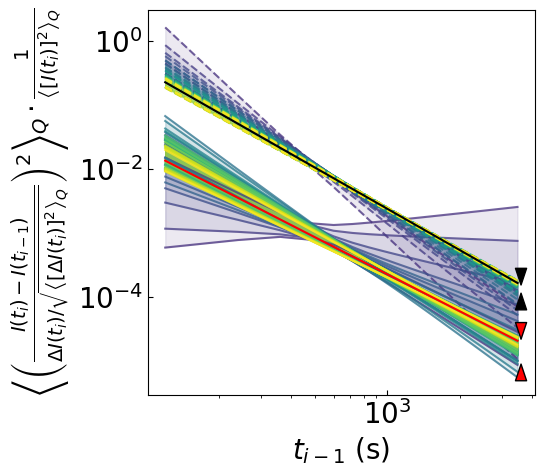

In [34]:
# plot the GPR result
fig2 = plt.figure(figsize=(5, 5))
ax2 = plt.subplot(1, 1, 1)
colors = plt.cm.viridis(np.linspace(0, 1, len(time_list)))

# fig3 = plt.figure(figsize=(5, 5))
# ax3 = plt.subplot(1, 1, 1)

# fig4 = plt.figure(figsize=(5, 5))
# ax4 = plt.subplot(1, 1, 1)

list_mse = []
list_mse_exp = []

log_time = np.log(time_list[:-1])
X_all = np.vstack([np.ones_like(log_time), log_time]).T
for i_t, time in enumerate(time_list):
    if i_t == 0:
        continue
    I_gp_prev = list_I_mean_gp[i_t-1]
    I_gp = list_I_mean_gp[i_t]
    I_gp_err = list_I_std_gp[i_t]

    data = data_list[i_t]
    q_data = data[:, 0]
    I_exp = data[:, 1]
    I_exp_err = data[:, 2]
    
    data_prev = data_list[i_t-1]
    q_data_prev = data_prev[:, 0]
    I_exp_prev = data_prev[:, 1]
    I_exp_err_prev = data_prev[:, 2]
    
    relative_err_Q = I_exp_err/np.sqrt(np.mean(I_exp_err**2))*np.sqrt(np.mean(I_exp**2)) # dimensionless
    
    # ax2.plot(time, np.mean(((I_gp-I_gp_prev)/relative_err_Q)**2), 'o', color = colors[i_t], label = f'time {time:0.0f} min')
    # ax2.plot(time, np.mean(((I_exp-I_exp_prev)/relative_err_Q)**2), 'x', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_xlabel(r'$t_{i-1}\ (\mathrm{s})$', fontsize=20)
    ax2.set_ylabel(r'$\left\langle \left( \frac{I(t_i) - I(t_{i-1})}{\Delta I(t_i)/\sqrt{\left\langle \left[\Delta I(t_i)\right]^2 \right\rangle_Q}} \right)^2 \right\rangle_Q \cdot \frac{ 1 }{ \left\langle \left[I(t_i)\right]^2 \right\rangle_Q }$', 
                   fontsize=20)
    ax2.tick_params(direction='in', labelsize=20)
    
    
    list_mse.append(np.mean(((I_gp-I_gp_prev)/relative_err_Q)**2))
    list_mse_exp.append(np.mean(((I_exp-I_exp_prev)/relative_err_Q)**2))
    
    time_current = time_list[2:i_t+1]
    if i_t <= 3:
        continue
    log_time_current = np.log(time_current)
    log_mse_current = np.log(list_mse[1:i_t+1])
    log_mse_exp_current = np.log(list_mse_exp[1:i_t+1])
    # Prepare the X matrix with ones and log_time
    X_current = np.vstack([np.ones_like(log_time_current), log_time_current]).T
    # Fit on current subset
    A_current, _, _, _ = np.linalg.lstsq(X_current, log_mse_current, rcond=None)
    A_exp_current, _, _, _ = np.linalg.lstsq(X_current, log_mse_exp_current, rcond=None)

    # Predict over full time grid
    y_pred_all = X_all @ A_current
    y_pred_all_exp = X_all @ A_exp_current

    # Residuals from current subset
    resid_var = np.var(log_mse_current - (X_current @ A_current))
    resid_var_exp = np.var(log_mse_exp_current - (X_current @ A_exp_current))

    # Covariance from current subset
    cov_A = resid_var * np.linalg.inv(X_current.T @ X_current)
    cov_A_exp = resid_var_exp * np.linalg.inv(X_current.T @ X_current)

    # 95% CI on global predictor grid
    z_val = 1
    ci_std = np.sqrt(np.sum(X_all @ cov_A * X_all, axis=1))
    ci_std_exp = np.sqrt(np.sum(X_all @ cov_A_exp * X_all, axis=1))

    upper_ci = y_pred_all + z_val * ci_std
    lower_ci = y_pred_all - z_val * ci_std
    upper_ci_exp = y_pred_all_exp + z_val * ci_std_exp
    lower_ci_exp = y_pred_all_exp - z_val * ci_std_exp

    # Plot CI bands
    ax2.fill_between(time_list[:-1], np.exp(lower_ci), np.exp(upper_ci), color=colors[i_t], alpha=0.1)
    ax2.fill_between(time_list[:-1], np.exp(lower_ci_exp), np.exp(upper_ci_exp), color=colors[i_t], alpha=0.1)
    ax2.plot(time_list[:-1], np.exp(upper_ci), '-', color=colors[i_t], alpha=0.75, label='Upper CI')
    ax2.plot(time_list[:-1], np.exp(lower_ci), '-', color=colors[i_t], alpha=0.75, label='Lower CI')
    ax2.plot(time_list[:-1], np.exp(upper_ci_exp), '--', color=colors[i_t], alpha=0.75, label='Upper CI Exp')
    ax2.plot(time_list[:-1], np.exp(lower_ci_exp), '--', color=colors[i_t], alpha=0.75, label='Lower CI Exp')
    
    if i_t == 13:
        upper_ci_early = upper_ci
        lower_ci_early = lower_ci
        upper_ci_exp_early = upper_ci_exp
        lower_ci_exp_early = lower_ci_exp
        
# Use the saved early estimates for plotting

ax2.annotate('', xy=(time_list[-1], np.exp(lower_ci_early[-1])), 
            xytext=(time_list[-1], np.exp(lower_ci_early[-1]*1.02)),
            arrowprops=dict(facecolor='r', shrink=0.05, width=2, headwidth=8))
ax2.annotate('', xy=(time_list[-1], np.exp(lower_ci_exp_early[-1])),
            xytext=(time_list[-1], np.exp(lower_ci_exp_early[-1]*1.02)),
            arrowprops=dict(facecolor='k', shrink=0.05, width=2, headwidth=8))

ax2.annotate('', xy=(time_list[-1], np.exp(upper_ci_early[-1])), 
            xytext=(time_list[-1], np.exp(upper_ci_early[-1]*0.98)),
            arrowprops=dict(facecolor='r', shrink=0.05, width=2, headwidth=8))
ax2.annotate('', xy=(time_list[-1], np.exp(upper_ci_exp_early[-1])),
            xytext=(time_list[-1], np.exp(upper_ci_exp_early[-1]*0.98)),
            arrowprops=dict(facecolor='k', shrink=0.05, width=2, headwidth=8))
    
#     ax3.plot(time, np.sqrt(np.mean(1/relative_err_Q**2)), 'o')
#     ax4.plot(time, np.mean(I_exp_err**2), 'o')
#     ax4.plot(time, 20000/(time/time_list[0])**2, 'x')
# ax3.set_xscale('log')
# ax3.set_yscale('log')
# ax3.set_ylim(1e-1, 1e-0)
# ax4.set_xscale('log')
# ax4.set_yscale('log')
# ax4.set_ylim(1e-2, 1e-0)

# convert the lists to numpy arrays
list_mse = np.array(list_mse)
list_mse_exp = np.array(list_mse_exp)
    
log_mse = np.log(list_mse)
log_mse_exp = np.log(list_mse_exp)

# Prepare the X matrix with ones and log_time
X = np.vstack([np.ones_like(log_time), log_time]).T

# Solve for coefficients using least squares
A, _, _, _ = np.linalg.lstsq(X, log_mse, rcond=None)
A_exp, _, _, _ = np.linalg.lstsq(X, log_mse_exp, rcond=None)

slope, intercept = A[1], A[0]
slope_exp, intercept_exp = A_exp[1], A_exp[0]

# ax2.plot(time_list[1:], np.exp(intercept + slope * log_time), color='r', alpha=1)
# ax2.plot(time_list[1:], np.exp(intercept_exp + slope_exp * log_time), color='k', alpha=1)

ax2.plot(time_list[:-1], np.exp(y_pred_all), color='r', alpha=1)
ax2.plot(time_list[:-1], np.exp(y_pred_all_exp), color='k', alpha=1)

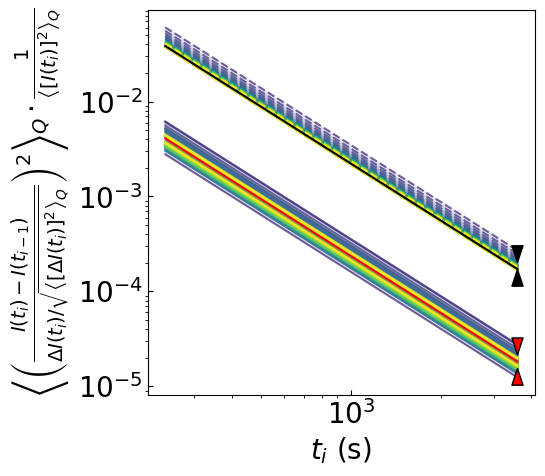

In [8]:
# plot the GPR result
fig2 = plt.figure(figsize=(5, 5))
ax2 = plt.subplot(1, 1, 1)
colors = plt.cm.viridis(np.linspace(0, 1, len(time_list)))

# fig3 = plt.figure(figsize=(5, 5))
# ax3 = plt.subplot(1, 1, 1)

# fig4 = plt.figure(figsize=(5, 5))
# ax4 = plt.subplot(1, 1, 1)

list_mse = []
list_mse_exp = []

log_time = np.log(time_list[1:])
X_all = np.vstack([np.ones_like(log_time), log_time]).T
for i_t, time in enumerate(time_list):
    if i_t == 0:
        continue
    I_gp_prev = list_I_mean_gp[i_t-1]
    I_gp = list_I_mean_gp[i_t]
    I_gp_err = list_I_std_gp[i_t]

    data = data_list[i_t]
    q_data = data[:, 0]
    I_exp = data[:, 1]
    I_exp_err = data[:, 2]
    
    data_prev = data_list[i_t-1]
    q_data_prev = data_prev[:, 0]
    I_exp_prev = data_prev[:, 1]
    I_exp_err_prev = data_prev[:, 2]
    
    relative_err_Q = I_exp_err/np.sqrt(np.mean(I_exp_err**2))*np.sqrt(np.mean(I_exp**2)) # dimensionless
    
    # ax2.plot(time, np.mean(((I_gp-I_gp_prev)/relative_err_Q)**2), 'o', color = colors[i_t], label = f'time {time:0.0f} min')
    # ax2.plot(time, np.mean(((I_exp-I_exp_prev)/relative_err_Q)**2), 'x', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_xlabel(r'$t_i\ (\mathrm{s})$', fontsize=20)
    ax2.set_ylabel(r'$\left\langle \left( \frac{I(t_i) - I(t_{i-1})}{\Delta I(t_i)/\sqrt{\left\langle \left[\Delta I(t_i)\right]^2 \right\rangle_Q}} \right)^2 \right\rangle_Q \cdot \frac{ 1 }{ \left\langle \left[I(t_i)\right]^2 \right\rangle_Q }$', 
                   fontsize=20)
    ax2.tick_params(direction='in', labelsize=20)
    
    
    list_mse.append(np.mean(((I_gp-I_gp_prev)/relative_err_Q)**2))
    list_mse_exp.append(np.mean(((I_exp-I_exp_prev)/relative_err_Q)**2))
    
    time_current = time_list[2:i_t+1]
    if i_t <= 3:
        continue
    log_time_current = np.log(time_current)
    log_mse_current = np.log(list_mse[1:i_t+1])
    log_mse_exp_current = np.log(list_mse_exp[1:i_t+1])
    
    fixed_slope = -2

    # Fit intercept for log_mse and log_mse_exp with fixed slope
    intercept_current = np.mean(log_mse_current + 2 * log_time_current)
    intercept_exp_current = np.mean(log_mse_exp_current + 2 * log_time_current)

    # Evaluate prediction on full time grid
    y_pred_all = intercept_current + fixed_slope * log_time
    y_pred_all_exp = intercept_exp_current + fixed_slope * log_time

    # Residuals from fixed-slope fit
    resid_current = log_mse_current - (intercept_current + fixed_slope * log_time_current)
    resid_exp_current = log_mse_exp_current - (intercept_exp_current + fixed_slope * log_time_current)

    # Residual variance
    resid_var = np.var(resid_current, ddof=1)
    resid_var_exp = np.var(resid_exp_current, ddof=1)

    # Covariance of the intercept estimate: Var(intercept) = σ² / N
    N = len(log_time_current)
    intercept_var = resid_var / N
    intercept_var_exp = resid_var_exp / N

    # Gradient: dy/dα = 1 → std dev of prediction at each point = sqrt(intercept_var)
    ci_std = np.sqrt(intercept_var) * np.ones_like(log_time)
    ci_std_exp = np.sqrt(intercept_var_exp) * np.ones_like(log_time)

    # 1σ Confidence Interval
    z_val = 1
    upper_ci = y_pred_all + z_val * ci_std
    lower_ci = y_pred_all - z_val * ci_std
    upper_ci_exp = y_pred_all_exp + z_val * ci_std_exp
    lower_ci_exp = y_pred_all_exp - z_val * ci_std_exp

    # Plot CI bands
    ax2.fill_between(time_list[1:], np.exp(lower_ci), np.exp(upper_ci), color=colors[i_t], alpha=0.1)
    ax2.fill_between(time_list[1:], np.exp(lower_ci_exp), np.exp(upper_ci_exp), color=colors[i_t], alpha=0.1)
    ax2.plot(time_list[1:], np.exp(upper_ci), '-', color=colors[i_t], alpha=0.75, label='Upper CI')
    ax2.plot(time_list[1:], np.exp(lower_ci), '-', color=colors[i_t], alpha=0.75, label='Lower CI')
    ax2.plot(time_list[1:], np.exp(upper_ci_exp), '--', color=colors[i_t], alpha=0.75, label='Upper CI Exp')
    ax2.plot(time_list[1:], np.exp(lower_ci_exp), '--', color=colors[i_t], alpha=0.75, label='Lower CI Exp')
    
    if i_t == 10:
        upper_ci_early = upper_ci
        lower_ci_early = lower_ci
        upper_ci_exp_early = upper_ci_exp
        lower_ci_exp_early = lower_ci_exp
        
# Use the saved early estimates for plotting

ax2.annotate('', xy=(time_list[-1], np.exp(lower_ci_early[-1])), 
            xytext=(time_list[-1], np.exp(lower_ci_early[-1]*1.02)),
            arrowprops=dict(facecolor='r', shrink=0.05, width=2, headwidth=8))
ax2.annotate('', xy=(time_list[-1], np.exp(lower_ci_exp_early[-1])),
            xytext=(time_list[-1], np.exp(lower_ci_exp_early[-1]*1.02)),
            arrowprops=dict(facecolor='k', shrink=0.05, width=2, headwidth=8))

ax2.annotate('', xy=(time_list[-1], np.exp(upper_ci_early[-1])), 
            xytext=(time_list[-1], np.exp(upper_ci_early[-1]*0.98)),
            arrowprops=dict(facecolor='r', shrink=0.05, width=2, headwidth=8))
ax2.annotate('', xy=(time_list[-1], np.exp(upper_ci_exp_early[-1])),
            xytext=(time_list[-1], np.exp(upper_ci_exp_early[-1]*0.98)),
            arrowprops=dict(facecolor='k', shrink=0.05, width=2, headwidth=8))
    
#     ax3.plot(time, np.sqrt(np.mean(1/relative_err_Q**2)), 'o')
#     ax4.plot(time, np.mean(I_exp_err**2), 'o')
#     ax4.plot(time, 20000/(time/time_list[0])**2, 'x')
# ax3.set_xscale('log')
# ax3.set_yscale('log')
# ax3.set_ylim(1e-1, 1e-0)
# ax4.set_xscale('log')
# ax4.set_yscale('log')
# ax4.set_ylim(1e-2, 1e-0)

# convert the lists to numpy arrays
list_mse = np.array(list_mse)
list_mse_exp = np.array(list_mse_exp)
    
log_mse = np.log(list_mse)
log_mse_exp = np.log(list_mse_exp)

# Prepare the X matrix with ones and log_time
X = np.vstack([np.ones_like(log_time), log_time]).T

# Solve for coefficients using least squares
A, _, _, _ = np.linalg.lstsq(X, log_mse, rcond=None)
A_exp, _, _, _ = np.linalg.lstsq(X, log_mse_exp, rcond=None)

slope, intercept = A[1], A[0]
slope_exp, intercept_exp = A_exp[1], A_exp[0]

# ax2.plot(time_list[1:], np.exp(intercept + slope * log_time), color='r', alpha=1)
# ax2.plot(time_list[1:], np.exp(intercept_exp + slope_exp * log_time), color='k', alpha=1)

# ax2.plot(time_list[1:], np.exp(y_pred_all), color='r', alpha=1)
# ax2.plot(time_list[1:], np.exp(y_pred_all_exp), color='k', alpha=1)

ax2.plot(time_list[1:], np.exp(y_pred_all), color='r', alpha=1)
ax2.plot(time_list[1:], np.exp(y_pred_all_exp), color='k', alpha=1)

0
2
8
28


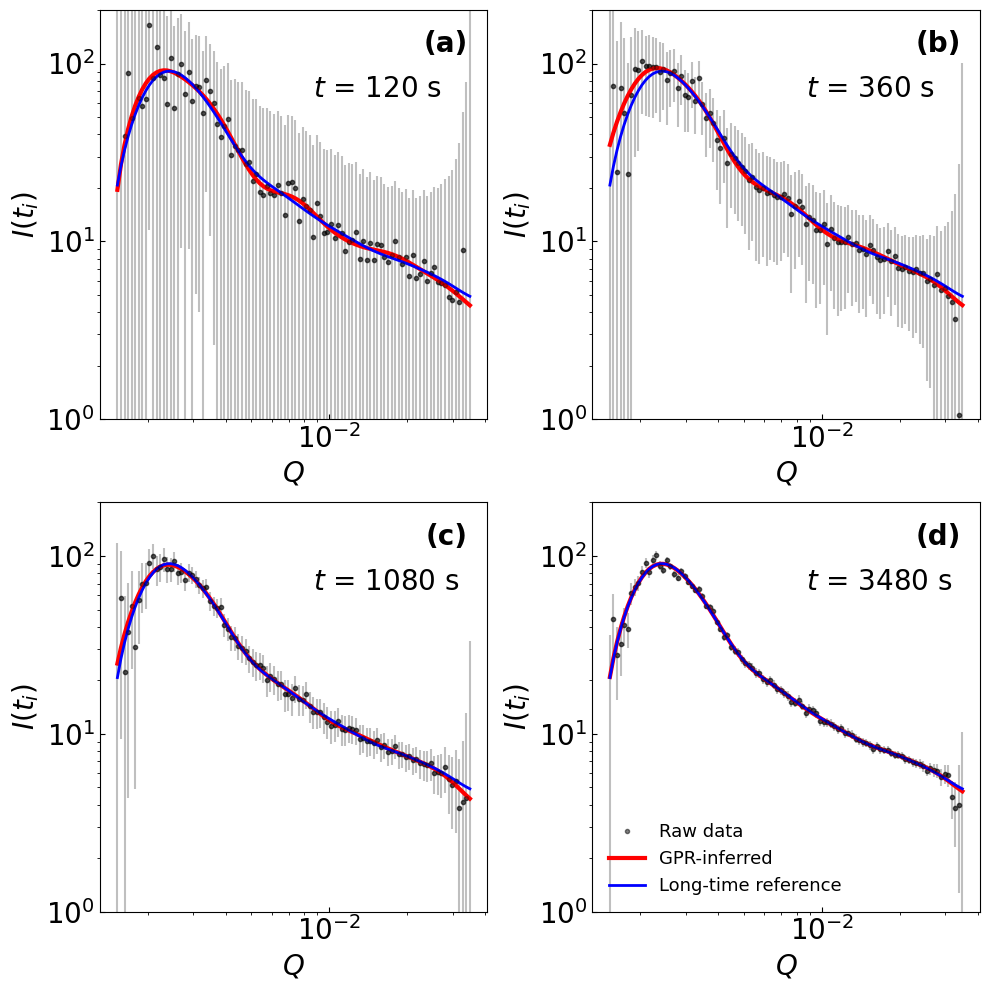

In [9]:
# plot the GPR result
fig = plt.figure(figsize=(10, 10))

colors = plt.cm.viridis(np.linspace(0, 1, len(time_list)))

list_mse = []
list_mse_exp = []

i_selected = np.logspace(0, np.log10(len(time_list)), 4).astype(int)-1

panel_labels = ['(a)', '(b)', '(c)', '(d)']

i_ax = 1
for i_t, time in enumerate(time_list):
    if i_t not in i_selected:
        continue
    print(i_t)

    ax = plt.subplot(2, 2, i_ax)
    i_ax+= 1
    
    I_gp_prev = list_I_mean_gp[i_t-1]
    I_gp = list_I_mean_gp[i_t]
    I_gp_err = list_I_std_gp[i_t]
    
    i_gp_end = list_I_mean_gp[len(list_I_mean_gp)-1]

    data = data_list[i_t]
    q_data = data[:, 0]
    I_exp = data[:, 1]
    I_exp_err = data[:, 2]
    
    data_prev = data_list[i_t-1]
    q_data_prev = data_prev[:, 0]
    I_exp_prev = data_prev[:, 1]
    I_exp_err_prev = data_prev[:, 2]
    
    relative_err_Q = I_exp_err/np.sqrt(np.mean(I_exp_err**2))*np.sqrt(np.mean((I_exp-np.mean(I_exp))**2)) # dimensionless
    
    ax.plot(q_s, I_exp, '.', color='k', alpha=0.5)
    ax.errorbar(q_data, I_exp, yerr=I_exp_err, fmt='.', color='k', alpha=0.25, label=r'Raw data')
    ax.plot(q_s, I_gp, '-', color='r', lw=3, label=r'GPR-inferred')
    ax.plot(q_s, i_gp_end, '-', color='b', lw=2, label=r'Long-time reference')
    
    ax.set_xlabel(r'$Q$', fontsize=20)
    ax.set_ylabel(r'$I(t_i)$', fontsize=20)
    ax.set_xscale('log')
    ax.tick_params(direction='in', labelsize=20)
    # ax3.set_yscale('log')
    ax.set_ylim([1, 200])
    ax.set_yscale('log')
    
    ax.text(0.95, 0.95, panel_labels[i_ax-2], transform=ax.transAxes, fontsize=20, verticalalignment='top', horizontalalignment='right', fontweight='bold')
    
    ax.text(0.55, 0.84, f'$t$ = {time:0.0f} s', transform=ax.transAxes, fontsize=20,
            verticalalignment='top', horizontalalignment='left',
            )
    
    if i_ax == 5:
        ax.legend(['Raw data', 'GPR-inferred', 'Long-time reference'], frameon=False, fontsize=13, ncol=1, loc='lower left')

# ax3 = plt.subplot(2, 3, 4)
# ax4 = plt.subplot(2, 3, 5)    
# for i_t, time in enumerate(time_list):
#     if i_t == 0:
#         continue
#     I_gp_prev = list_I_mean_gp[i_t-1]
#     I_gp = list_I_mean_gp[i_t]
#     I_gp_err = list_I_std_gp[i_t]

#     data = data_list[i_t]
#     q_data = data[:, 0]
#     I_exp = data[:, 1]
#     I_exp_err = data[:, 2]
    
#     data_prev = data_list[i_t-1]
#     q_data_prev = data_prev[:, 0]
#     I_exp_prev = data_prev[:, 1]
#     I_exp_err_prev = data_prev[:, 2]
    
#     relative_err_Q = I_exp_err/np.sqrt(np.mean(I_exp_err**2))*np.sqrt(np.mean((I_exp-np.mean(I_exp))**2)) # dimensionless
    
#     ax3.plot(q_s, I_gp_prev, '-', color = colors[i_t])
#     ax3.set_xlabel(r'$Q$', fontsize=20)
#     ax3.set_ylabel(r'$I(t_i)$', fontsize=20)
#     ax3.set_xscale('log')
#     ax3.tick_params(direction='in', labelsize=20)
#     # ax3.set_yscale('log')
#     ax3.set_ylim([0, 120])
#     ylim = ax3.get_ylim()
    
#     ax4.errorbar(q_data, I_exp, yerr=I_exp_err, fmt='.', color = colors[i_t])
#     ax4.set_xlabel(r'$Q$', fontsize=20)
#     ax4.set_ylabel(r'$I(t_i)$', fontsize=20)
#     ax4.set_xscale('log')
#     ax4.tick_params(direction='in', labelsize=20)
#     ax4.set_ylim(ylim)
#     # ax4.set_yscale('log')
    
#     list_mse.append(np.mean(((I_gp-I_gp_prev)/relative_err_Q)**2))
#     list_mse_exp.append(np.mean(((I_exp-I_exp_prev)/relative_err_Q)**2))
 
plt.tight_layout()

In [10]:
i_selected

array([ 0,  2,  8, 28])

## EQSANS-SDS

In [11]:
# Define the folder path
folder_path = './data/EQSANS/SDS/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[6]) for filename in filenames if filename.endswith('.dat')])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f'SDS_5mgmL_20C_4m_fbt_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt('./data/EQSANS/SDS/'+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])
    
filename_list = [f'SDS_5mgmL_20C_4m_fbt_0_{i:0.0f}_Iqxqy.dat' for i in time_list]
label_list = [f'time_0_{i:0.0f}' for i in time_list]
data_2D_list = []

for i_file, filename in enumerate(filename_list):
    data = np.loadtxt('./data/EQSANS/SDS/'+filename, skiprows=4)
    data_2D_list.append(data)

0 1.0
1 2.0
2 3.0
3 4.0
4 5.0
5 6.0
6 7.0
7 8.0
8 9.0
9 10.0
10 15.0
11 20.0
12 25.0
13 30.0
14 60.0
15 90.0
16 120.0
17 240.0
18 360.0
19 480.0
20 600.0
21 720.0


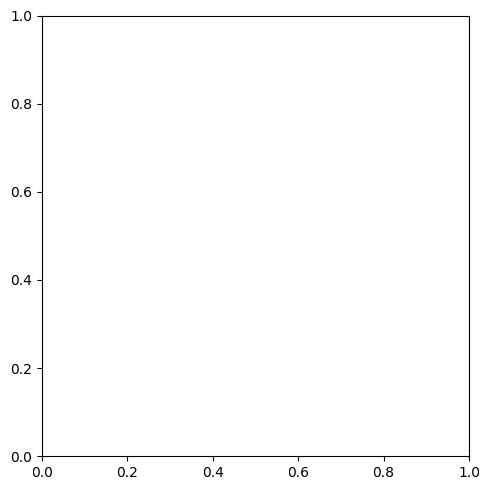

In [12]:
n_trial = 1
filter_size = 0.5
I_bg = 0.001
use_log_I = False
use_log_Q = True

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

fig = plt.figure(figsize=(5, 5))

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 7, 13)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []

list_I_mean_gp = []
list_I_std_gp = []

for i_t, time in enumerate(time_list):
    
    ax = plt.subplot(1, 1, 1)

    color = get_viridis_color(i_t/(len(time_list)-1))


    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        # The noisy data
        index_data = i_t
        data = data_list[index_data]
        q_data = data[:, 0]
        I_data = data[:, 1]
        I_err_data = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data)):
            if I_err_data[i] == 0:
                I_err_data[i] = I_err_data[i - 1]
                
        # The smooth data
        index_data_good = len(time_list)-1
        data = data_list[index_data_good]
        q_data_good = data[:, 0]
        I_data_good = data[:, 1]
        I_err_data_good = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data_good)):
            if I_err_data_good[i] == 0:
                I_err_data_good[i] = I_err_data_good[i - 1]
                
        index_outlier_sm = (q_data > 0.4)|(q_data < 0.015)  
        index_outlier = (q_data < 0.4)&(q_data > 0.015)
        
        I_q_gf = np.zeros_like(q_data)
        for i_iterate in range(1):
            I_q_gf_i = np.zeros_like(q_data)
            I_iterate = I_data - I_q_gf
            for i in range(len(q_data)):
                weight_list = np.exp(-((f_Q(q_data[i])-f_Q(q_data))/filter_size)**2/2)
                weight_list[index_outlier_sm] = 0
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 1
            I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q_data), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i

        ## GPR
        sigma_list = np.logspace(-1, 3, 25)
        log_likelihood_list = []

        lmbda = 0.225
        # sigma = 10

        ## define kernel function
        y_data = f_I(I_data)
        y_gt = f_I(I_data_good)
        y_bg = f_I(I_q_gf)
        # y_bg = y_gt
        y = y_data-y_bg

        # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
        y_err_pixel = I_err_data
        y_err = y_err_pixel
        if use_log_I:
            y_err = y_err_pixel*f_loglin_deriv(I_data, x_c=I_bg)

        # scale by a factor to check whether error estimation is correct
        m_factor = 1
        y_bg = y_bg*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
        y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
        y_data = y_data*m_factor
        sig_var = np.mean(y[index_outlier]**2)
        
        # fluctuations of the prior distribution
        prior_sigma = np.sqrt(sig_var)
        # prior_sigma = np.sqrt(np.mean(y_err**2))
        # prior_sigma = np.sqrt(y_err**2+sig_var) 

        q_x = q_data
        q_s = q_data

        def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
            if std_1 is None:
                std_1 = np.ones_like(q1)
            if std_2 is None:
                std_2 = np.ones_like(q2)
            K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
            return K
            
        # for sigma in sigma_list:
        #     f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
        #     K_sigma = np.diag(f_y_err(y_err))
        #     # K_sigma = sigma**2*np.eye(len(q_x))
        #     K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
        #     K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        #     k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        #     L = np.linalg.cholesky(K_xx)
        #     alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        #     v = np.linalg.solve(L, K_xs)
        #     mu_s = K_xs.T @ alpha
        #     cov_s = k_ss - v.T @ v
        #     var_s = np.diag(cov_s)*prior_sigma**2
        #     std_s = np.sqrt(var_s)

        #     # evaluate the log likelihood
        #     log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
        #     log_likelihood_list.append(log_likelihood)
            
        # log_likelihood_list = np.array(log_likelihood_list)
        # log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        # ax.plot(sigma_list, log_likelihood_list, '-', color=color)
        # ax.set_xscale('log')
        # ax.set_ylim([-5, 5])
        # ax.tick_params(direction='in', labelsize=20)
        # ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        # ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        # sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        sigma_best = 1
        
        # ax.legend(frameon=False, fontsize=13, ncol=2)
        plt.tight_layout()

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_data, x_c=I_bg)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy      
        # h_gt_m = -f_log_likelihood((y_gt), sigma_gt, (y_bg), prior_sigma, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        # h_gt_gpr = -f_log_likelihood((y_gt), sigma_gt, (mu_s + y_bg), std_s, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        # h_gt_exp = -f_log_likelihood((y_gt), sigma_gt, (y_data), y_err, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        
        importance = np.where((q_data > 0.014)&(q_data < 0.4), 1, 0)
        # importance = None
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
        # likelihood of gt within the experimental prediction
        # log_likelihood_gt_exp += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), f_inv_I(y_data), y_err_pixel)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_exp += f_log_likelihood((y_gt), sigma_gt, y_data, y_err_pixel)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # likelihood of gt within the GPR prediction
        # log_likelihood_gt_gpr += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), I_mean_GP, I_std_GP)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_gpr += f_log_likelihood((y_gt), sigma_gt, mu_s + y_bg, std_s)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # mean squared error of gt and experimental prediction
        # mse_exp += f_mse(y + y_bg, y_gt)
        mse_exp += f_mse(f_inv_I(y_data),f_inv_I(y_gt))
        
        # mean squared error of gt and GPR prediction
        # mse_gpr += f_mse(mu_s + y_bg, y_gt)
        mse_gpr += f_mse(I_mean_GP, f_inv_I(y_gt))
        
    list_L_exp.append(log_likelihood_gt_exp/n_trial)
    list_L_gpr.append(log_likelihood_gt_gpr/n_trial)
    list_mse_exp.append(mse_exp/n_trial)
    list_mse_gpr.append(mse_gpr/n_trial)
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)
    
    list_I_mean_gp.append(I_mean_GP)
    list_I_std_gp.append(I_std_GP)

# convert the lists to numpy arrays
list_L_exp = np.array(list_L_exp)
list_L_gpr = np.array(list_L_gpr)
list_mse_exp = np.array(list_mse_exp)
list_mse_gpr = np.array(list_mse_gpr)
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

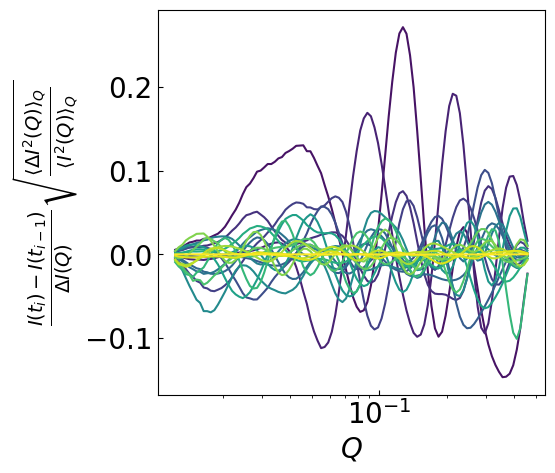

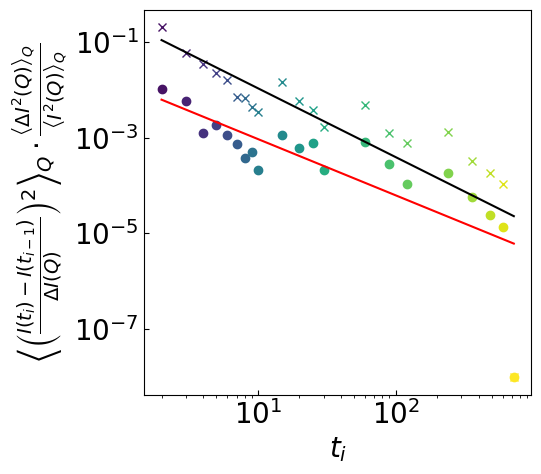

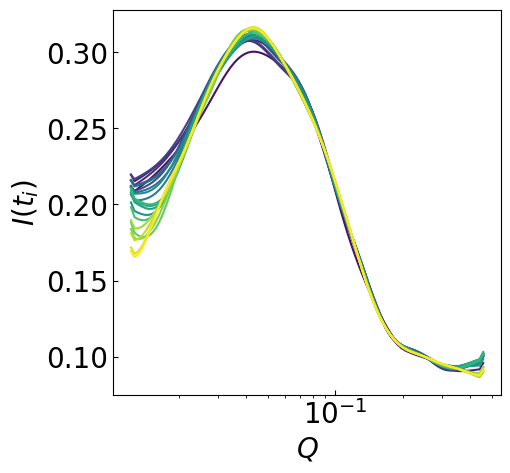

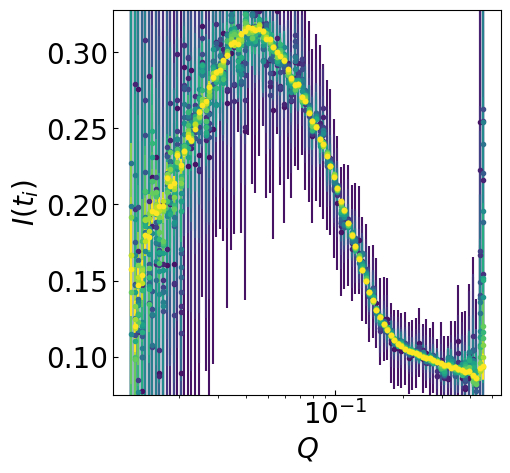

In [13]:
# plot the GPR result
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

fig2 = plt.figure(figsize=(5, 5))
ax2 = plt.subplot(1, 1, 1)

fig3 = plt.figure(figsize=(5, 5))
ax3 = plt.subplot(1, 1, 1)

fig4 = plt.figure(figsize=(5, 5))
ax4 = plt.subplot(1, 1, 1)

colors = plt.cm.viridis(np.linspace(0, 1, len(time_list)))

list_mse = []
list_mse_exp = []

for i_t, time in enumerate(time_list):
    if i_t == 0:
        continue
    I_gp_prev = list_I_mean_gp[i_t-1]
    I_gp = list_I_mean_gp[i_t]
    I_gp_err = list_I_std_gp[i_t]

    data = data_list[i_t]
    q_data = data[:, 0]
    I_exp = data[:, 1]
    I_exp_err = data[:, 2]
    
    data_prev = data_list[i_t-1]
    q_data_prev = data_prev[:, 0]
    I_exp_prev = data_prev[:, 1]
    I_exp_err_prev = data_prev[:, 2]
    
    relative_err_Q = I_exp_err/np.sqrt(np.mean(I_exp_err**2))*np.sqrt(np.mean(I_exp**2)) # dimensionless
    
    ax.plot(q_s, (I_gp-I_gp_prev)/relative_err_Q, '-', color = colors[i_t])
    ax.set_xlabel(r'$Q$', fontsize=20)
    ax.set_ylabel(r'$\frac{I(t_i) - I(t_{i-1})}{\Delta I(Q)} \sqrt{\frac{\langle \Delta I^2(Q) \rangle_Q}{\langle I^2(Q) \rangle_Q}}$', fontsize=20)
    ax.set_xscale('log')
    ax.tick_params(direction='in', labelsize=20)
    
    ax2.plot(time, np.mean(((I_gp-I_gp_prev)/relative_err_Q)**2), 'o', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.plot(time, np.mean(((I_exp-I_exp_prev)/relative_err_Q)**2), 'x', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_xlabel(r'$t_i$', fontsize=20)
    ax2.set_ylabel(r'$\left\langle \left( \frac{I(t_i) - I(t_{i-1})}{\Delta I(Q)} \right)^2 \right\rangle_Q \cdot \frac{ \left\langle \Delta I^2(Q) \right\rangle_Q }{ \left\langle I^2(Q) \right\rangle_Q }$', fontsize=20)
    ax2.tick_params(direction='in', labelsize=20)
    
    ax3.plot(q_s, I_gp_prev, '-', color = colors[i_t])
    ax3.set_xlabel(r'$Q$', fontsize=20)
    ax3.set_ylabel(r'$I(t_i)$', fontsize=20)
    ax3.set_xscale('log')
    ax3.tick_params(direction='in', labelsize=20)
    # ax3.set_yscale('log')
    # ax3.set_ylim([0, 120])
    ylim = ax3.get_ylim()
    
    ax4.errorbar(q_data, I_exp, yerr=I_exp_err, fmt='.', color = colors[i_t])
    ax4.set_xlabel(r'$Q$', fontsize=20)
    ax4.set_ylabel(r'$I(t_i)$', fontsize=20)
    ax4.set_xscale('log')
    ax4.tick_params(direction='in', labelsize=20)
    ax4.set_ylim(ylim)
    # ax4.set_yscale('log')
    
    list_mse.append(np.mean(((I_gp-I_gp_prev)/relative_err_Q)**2))
    list_mse_exp.append(np.mean(((I_exp-I_exp_prev)/relative_err_Q)**2))
# convert the lists to numpy arrays
list_mse = np.array(list_mse)
list_mse_exp = np.array(list_mse_exp)
    

log_time = np.log(time_list[1:])
log_mse = np.log(list_mse)
log_mse_exp = np.log(list_mse_exp)

# Prepare the X matrix with ones and log_time
X = np.vstack([np.ones_like(log_time), log_time]).T

# Solve for coefficients using least squares
A, _, _, _ = np.linalg.lstsq(X, log_mse, rcond=None)
A_exp, _, _, _ = np.linalg.lstsq(X, log_mse_exp, rcond=None)

slope, intercept = A[1], A[0]
slope_exp, intercept_exp = A_exp[1], A_exp[0]

ax2.plot(time_list[1:], np.exp(intercept + slope * log_time), color='r', alpha=1)
ax2.plot(time_list[1:], np.exp(intercept_exp + slope_exp * log_time), color='k', alpha=1)

## ws2 9m15a

In [14]:
# Define the folder path
folder_path = './data/EQSANS/output_22193/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[4]) for filename in filenames if filename.endswith('.dat') and '9m15a' in filename and 'ws2' in filename])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f'ws2_9m15a_time_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt(folder_path+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])

0 120.0
1 240.0
2 360.0
3 480.0
4 600.0
5 720.0
6 840.0
7 960.0
8 1080.0
9 1200.0
10 1320.0
11 1440.0
12 1560.0
13 1680.0
14 1800.0
15 1920.0
16 2040.0
17 2160.0
18 2280.0
19 2400.0
20 2520.0
21 2640.0
22 2760.0
23 2880.0
24 3000.0
25 3120.0
26 3240.0


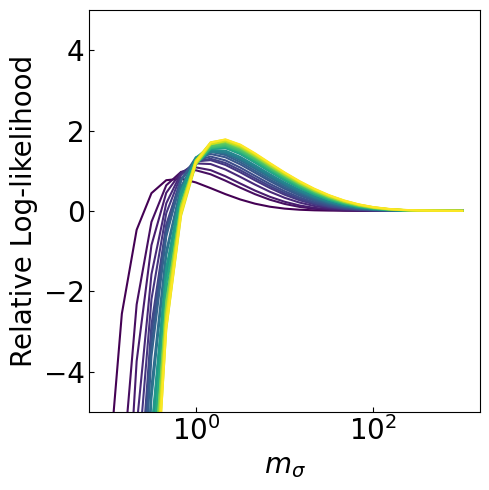

In [15]:
n_trial = 1
filter_size = 0.11
I_bg = 0.01
use_log_I = False
use_log_Q = True

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

fig = plt.figure(figsize=(5, 5))

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 7, 13)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []

list_I_mean_gp = []
list_I_std_gp = []

for i_t, time in enumerate(time_list):
    
    ax = plt.subplot(1, 1, 1)

    color = get_viridis_color(i_t/(len(time_list)-1))


    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        # The noisy data
        index_data = i_t
        data = data_list[index_data]
        q_data = data[:, 0]
        I_data = data[:, 1]
        I_err_data = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data)):
            if I_err_data[i] == 0:
                I_err_data[i] = I_err_data[i - 1]
                
        # The smooth data
        index_data_good = len(time_list)-1
        data = data_list[index_data_good]
        q_data_good = data[:, 0]
        I_data_good = data[:, 1]
        I_err_data_good = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data_good)):
            if I_err_data_good[i] == 0:
                I_err_data_good[i] = I_err_data_good[i - 1]
                
        index_outlier_sm = (q_data > 0.080)|(q_data < 0.001)  
        index_outlier = (q_data < 0.080)&(q_data > 0.001)
        
        I_q_gf = np.zeros_like(q_data)
        for i_iterate in range(1):
            I_q_gf_i = np.zeros_like(q_data)
            I_iterate = I_data - I_q_gf
            for i in range(len(q_data)):
                weight_list = np.exp(-((f_Q(q_data[i])-f_Q(q_data))/filter_size)**2/2)
                weight_list[index_outlier_sm] = 0
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 1
            # I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q_data), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i

        ## GPR
        sigma_list = np.logspace(-1, 3, 25)
        log_likelihood_list = []

        lmbda = 0.15
        # sigma = 10

        ## define kernel function
        y_data = f_I(I_data)
        y_gt = f_I(I_data_good)
        y_bg = f_I(I_q_gf)
        # y_bg = y_gt
        y = y_data-y_bg

        # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
        y_err_pixel = I_err_data
        y_err = y_err_pixel
        if use_log_I:
            y_err = y_err_pixel*f_loglin_deriv(I_data, x_c=I_bg*2)

        # scale by a factor to check whether error estimation is correct
        m_factor = 1
        y_bg = y_bg*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
        y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
        y_data = y_data*m_factor
        sig_var = np.mean(y[index_outlier]**2)
        
        # # exclude outliers
        # y_bg = y_bg[index_outlier]
        # y_gt = y_gt[index_outlier]
        # y = y[index_outlier]
        # y_err = y_err[index_outlier]
        # y_data = y_data[index_outlier]
        # q_data = q_data[index_outlier]

        # fluctuations of the prior distribution
        prior_sigma = np.sqrt(sig_var)
        # prior_sigma = np.sqrt(np.mean(y_err**2))
        # prior_sigma = np.sqrt(y_err**2+sig_var) 

        q_x = q_data
        q_s = q_data

        def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
            if std_1 is None:
                std_1 = np.ones_like(q1)
            if std_2 is None:
                std_2 = np.ones_like(q2)
            K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
            return K
            
        for sigma in sigma_list:
            f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
            K_sigma = np.diag(f_y_err(y_err))
            # K_sigma = sigma**2*np.eye(len(q_x))
            K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
            K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
            k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

            L = np.linalg.cholesky(K_xx)
            alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
            v = np.linalg.solve(L, K_xs)
            mu_s = K_xs.T @ alpha
            cov_s = k_ss - v.T @ v
            var_s = np.diag(cov_s)*prior_sigma**2
            std_s = np.sqrt(var_s)

            # evaluate the log likelihood
            log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
            log_likelihood_list.append(log_likelihood)
            
        log_likelihood_list = np.array(log_likelihood_list)
        log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        ax.plot(sigma_list, log_likelihood_list, '-', color=color)
        ax.set_xscale('log')
        ax.set_ylim([-5, 5])
        ax.tick_params(direction='in', labelsize=20)
        ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        # sigma_best = 1
        
        # ax.legend(frameon=False, fontsize=13, ncol=2)
        plt.tight_layout()

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_data, x_c=I_bg*2)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy              
        importance = np.where((q_data > 0.075)|(q_data < 0.001) , 0, 1)
        # importance = None
        
        # h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        # h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)

        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
        # likelihood of gt within the experimental prediction
        # log_likelihood_gt_exp += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), f_inv_I(y_data), y_err_pixel)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_exp += f_log_likelihood((y_gt), sigma_gt, y_data, y_err_pixel)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # likelihood of gt within the GPR prediction
        # log_likelihood_gt_gpr += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), I_mean_GP, I_std_GP)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_gpr += f_log_likelihood((y_gt), sigma_gt, mu_s + y_bg, std_s)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # mean squared error of gt and experimental prediction
        # mse_exp += f_mse(y + y_bg, y_gt)
        mse_exp += f_mse(f_inv_I(y_data),f_inv_I(y_gt))
        
        # mean squared error of gt and GPR prediction
        # mse_gpr += f_mse(mu_s + y_bg, y_gt)
        mse_gpr += f_mse(I_mean_GP, f_inv_I(y_gt))
        
    list_I_mean_gp.append(I_mean_GP)
    list_I_std_gp.append(I_std_GP)        
        
    list_L_exp.append(log_likelihood_gt_exp/n_trial)
    list_L_gpr.append(log_likelihood_gt_gpr/n_trial)
    list_mse_exp.append(mse_exp/n_trial)
    list_mse_gpr.append(mse_gpr/n_trial)
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)

# convert the lists to numpy arrays
list_L_exp = np.array(list_L_exp)
list_L_gpr = np.array(list_L_gpr)
list_mse_exp = np.array(list_mse_exp)
list_mse_gpr = np.array(list_mse_gpr)
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

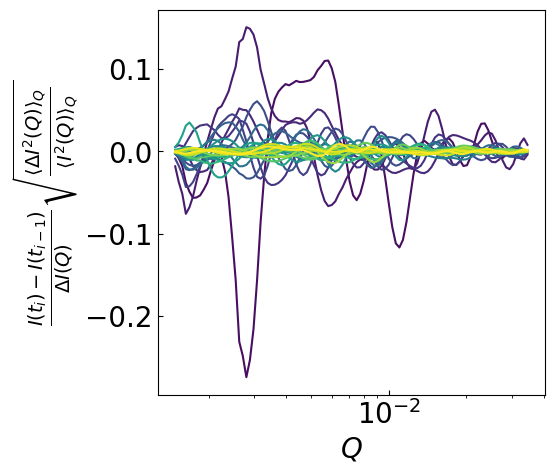

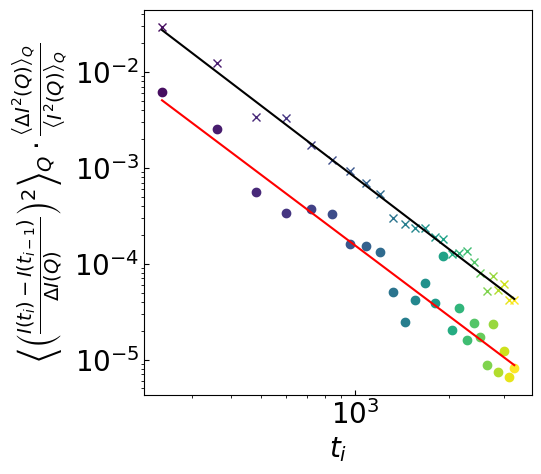

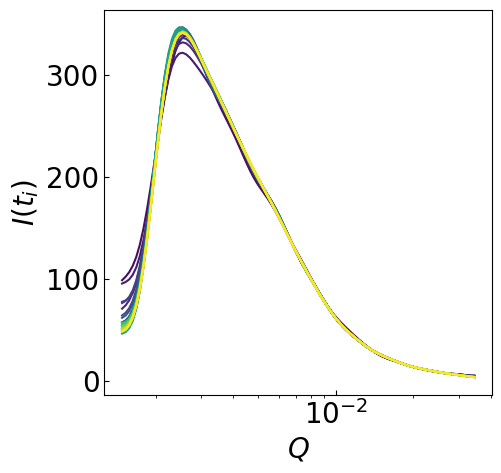

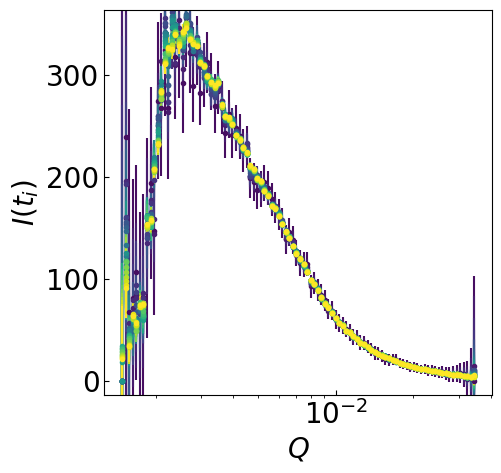

In [16]:
# plot the GPR result
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

fig2 = plt.figure(figsize=(5, 5))
ax2 = plt.subplot(1, 1, 1)

fig3 = plt.figure(figsize=(5, 5))
ax3 = plt.subplot(1, 1, 1)

fig4 = plt.figure(figsize=(5, 5))
ax4 = plt.subplot(1, 1, 1)

colors = plt.cm.viridis(np.linspace(0, 1, len(time_list)))

list_mse = []
list_mse_exp = []

for i_t, time in enumerate(time_list):
    if i_t == 0:
        continue
    I_gp_prev = list_I_mean_gp[i_t-1]
    I_gp = list_I_mean_gp[i_t]
    I_gp_err = list_I_std_gp[i_t]

    data = data_list[i_t]
    q_data = data[:, 0]
    I_exp = data[:, 1]
    I_exp_err = data[:, 2]
    
    data_prev = data_list[i_t-1]
    q_data_prev = data_prev[:, 0]
    I_exp_prev = data_prev[:, 1]
    I_exp_err_prev = data_prev[:, 2]
    
    relative_err_Q = I_exp_err/np.sqrt(np.mean(I_exp_err**2))*np.sqrt(np.mean(I_exp**2)) # dimensionless
    
    ax.plot(q_s, (I_gp-I_gp_prev)/relative_err_Q, '-', color = colors[i_t])
    ax.set_xlabel(r'$Q$', fontsize=20)
    ax.set_ylabel(r'$\frac{I(t_i) - I(t_{i-1})}{\Delta I(Q)} \sqrt{\frac{\langle \Delta I^2(Q) \rangle_Q}{\langle I^2(Q) \rangle_Q}}$', fontsize=20)
    ax.set_xscale('log')
    ax.tick_params(direction='in', labelsize=20)
    
    ax2.plot(time, np.mean(((I_gp-I_gp_prev)/relative_err_Q)**2), 'o', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.plot(time, np.mean(((I_exp-I_exp_prev)/relative_err_Q)**2), 'x', color = colors[i_t], label = f'time {time:0.0f} min')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_xlabel(r'$t_i$', fontsize=20)
    ax2.set_ylabel(r'$\left\langle \left( \frac{I(t_i) - I(t_{i-1})}{\Delta I(Q)} \right)^2 \right\rangle_Q \cdot \frac{ \left\langle \Delta I^2(Q) \right\rangle_Q }{ \left\langle I^2(Q) \right\rangle_Q }$', fontsize=20)
    ax2.tick_params(direction='in', labelsize=20)
    
    ax3.plot(q_s, I_gp_prev, '-', color = colors[i_t])
    ax3.set_xlabel(r'$Q$', fontsize=20)
    ax3.set_ylabel(r'$I(t_i)$', fontsize=20)
    ax3.set_xscale('log')
    ax3.tick_params(direction='in', labelsize=20)
    # ax3.set_yscale('log')
    # ax3.set_ylim([0, 120])
    ylim = ax3.get_ylim()
    
    ax4.errorbar(q_data, I_exp, yerr=I_exp_err, fmt='.', color = colors[i_t])
    ax4.set_xlabel(r'$Q$', fontsize=20)
    ax4.set_ylabel(r'$I(t_i)$', fontsize=20)
    ax4.set_xscale('log')
    ax4.tick_params(direction='in', labelsize=20)
    ax4.set_ylim(ylim)
    # ax4.set_yscale('log')
    
    list_mse.append(np.mean(((I_gp-I_gp_prev)/relative_err_Q)**2))
    list_mse_exp.append(np.mean(((I_exp-I_exp_prev)/relative_err_Q)**2))
# convert the lists to numpy arrays
list_mse = np.array(list_mse)
list_mse_exp = np.array(list_mse_exp)
    

log_time = np.log(time_list[1:])
log_mse = np.log(list_mse)
log_mse_exp = np.log(list_mse_exp)

# Prepare the X matrix with ones and log_time
X = np.vstack([np.ones_like(log_time), log_time]).T

# Solve for coefficients using least squares
A, _, _, _ = np.linalg.lstsq(X, log_mse, rcond=None)
A_exp, _, _, _ = np.linalg.lstsq(X, log_mse_exp, rcond=None)

slope, intercept = A[1], A[0]
slope_exp, intercept_exp = A_exp[1], A_exp[0]

ax2.plot(time_list[1:], np.exp(intercept + slope * log_time), color='r', alpha=1)
ax2.plot(time_list[1:], np.exp(intercept_exp + slope_exp * log_time), color='k', alpha=1)